<a href="https://colab.research.google.com/github/kcaat/Rpackage/blob/main/Datathon_5_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load in data
# data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #5/mhealth.csv')
data = pd.read_csv('mhealth.csv')

# drop subject 9 bc their distribution is different from the others
data = data[data['subject'] != 'subject9']

print(data.shape)
data.head()

(982273, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [ ]:
data.dtypes

alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

Split into Training and Testing


---



In [3]:
from sklearn.model_selection import train_test_split

# Grouping by 'subject' and creating a list of dataframes, one per group
grouped = data.groupby('subject')
grouped_data = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_data, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((753408, 14), (228865, 14))

Normalization

---



In [16]:
from sklearn.preprocessing import StandardScaler

# Identifying numerical columns (excluding 'subject' and 'Activity')
numerical_columns = train_df.select_dtypes(include=['float64']).columns.tolist()

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
print(train_df.shape)
train_df.head()

(753408, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
161280,-0.223286,-0.015393,0.477025,-0.908619,0.214578,1.202391,-0.274480,-0.415446,-0.151829,-1.317774,0.047213,-0.190632,0,subject2
161281,-0.247704,0.005929,0.454236,-0.919642,0.187503,1.187993,-0.303219,-0.417230,-0.154615,-1.317774,0.047213,-0.190632,0,subject2
161282,-0.242066,-0.010736,0.465339,-0.919642,0.187503,1.187993,-0.244074,-0.427635,-0.126097,-1.310525,0.043526,-0.171167,0,subject2
161283,-0.269487,0.036954,0.437693,-0.919642,0.187503,1.187993,-0.283765,-0.447419,-0.178098,-1.310525,0.043526,-0.171167,0,subject2
161284,-0.231693,-0.008528,0.449884,-0.934326,0.247080,1.173594,-0.298031,-0.449221,-0.183567,-1.310525,0.043526,-0.171167,0,subject2


Sequence Creation & Addressing Class Imbalance

---



In [5]:
# Sequence creation for Testing data with undersampling
import random

np.random.seed(42)

sensor_columns = ['alx','aly','alz','glx','gly','glz','arx','ary','arz','grx','gry','grz']

def create_sequences(data, sequence_length=100, train = True):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # Assuming 'Activity' is the target variable and is the same for the entire sequence
        label = sequence['Activity'].max()

        # Undersampling label 0
        if (label != 0 or random.random() > 0.95) and train == True: # undersample the 0 labels where there is a 95% chance to drop
          sequences.append(sequence[sensor_columns].values)
          output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=100, train = True)
X_test, y_test = create_sequences(test_df, sequence_length=100, train = False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2420, 100, 12), (2420,), (0,), (0,))

<Axes: ylabel='Count'>

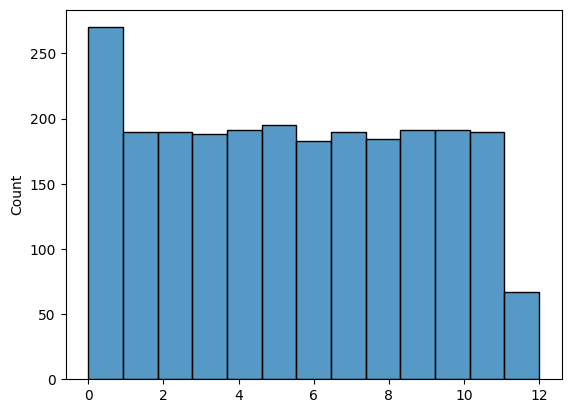

In [6]:
import seaborn as sns
# for i in range(len(y_train)):
#   print(y_train[i])

sns.histplot(y_train)

Training data looks more balanced now

Run LSTM Model

---



In [7]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameter Tuning
input_size = 12 # feature size of data
#hidden_size = 256  # Number of hidden units in LSTM
num_classes = 13  # For three-class classification
epochs = 10
learning_rate = 0.001
batch_size = 300
#landa = 0.001  # Regularization term (lambda)

- will need to tune parameters
- not sure what to set as hidden_size

In [8]:
# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# lstm layers and additional fully connected layer
lstm_layer1 = nn.LSTM(input_size, 8, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between lstm layers
fc_layer1 = nn.Linear(8, 4)  # Additional fully connected layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Final output layer
fc_layer2 = nn.Linear(4, num_classes)

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(lstm_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

In [15]:
# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = lstm_layer1(X)
        out = dropout1(out)  # Apply dropout between lstm layers
        # out = out[:, -1, :]  # Get the last output of the sequence
        out, _ = t.max(out, dim=1) # Get the max output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(lstm_layer1.parameters()) + list(lstm_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    lstm_layer1.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = lstm_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            #out = out[:, -1, :] # Get the last output of the sequence
            out, _ = t.max(out, dim=1) # Get the max output of the sequence
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()

        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = lstm_layer1(X)
            out = dropout1(out)  # Apply dropout between lstm layers
            #out = out[:, -1, :] # Get the last output of the sequence
            out, _ = t.max(out, dim=1) # Get the max output of the sequence
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
        train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    lstm_layer1.train()
    # rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

- Not sure if we want only the last output of the sequence if we initially generated it using the max
(out = out[:, -1, :])

In [ ]:
# Evaluation on training and validation data
lstm_layer1.eval()
fc_layer1.eval()
fc_layer2.eval()

with t.no_grad():
  # Training data
  train_correct, train_total = 0, 0
  for X, Y in train_data_loader:
    out, _ = lstm_layer1(X)
    out = dropout1(out)  # Apply dropout between RNN layers
#    out = out[:, -1, :] # Get the last output of the sequence
    out, _ = t.max(out, dim=1) # Get the max output of the sequence
    out = relu(fc_layer1(out))
    out = dropout_fc(out)  # Apply dropout between fully connected layers
    out = fc_layer2(out)
    _, predicted = t.max(out.data, 1)
    train_total += Y.size(0)
    train_correct += (predicted == Y).sum().item()

  train_accuracy = 100 * train_correct / train_total

In [ ]:
 # Validation data
validation_correct, validation_total = 0, 0
for X, Y in test_data_loader:
  out, _ = lstm_layer1(X)
  out = dropout1(out)  # Apply dropout between lstm layers
#  out = out[:, -1, :] # Get the last output of the sequence
  out, _ = t.max(out, dim=1) # Get the max output of the sequence
  out = relu(fc_layer1(out))
  out = dropout_fc(out)  # Apply dropout between fully connected layers
  out = fc_layer2(out)
  _, predicted = t.max(out.data, 1)
  validation_total += Y.size(0)
  validation_correct += (predicted == Y).sum().item()

validation_accuracy = 100 * validation_correct / validation_total

ZeroDivisionError: ignored

In [ ]:
 # Print accuracy for the current epoch
print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

# Append accuracy values to lists
train_accuracy_list.append(train_accuracy)
validation_accuracy_list.append(validation_accuracy)

Epoch 9/10 ---> Train Accuracy: 97.00499168053244%, Validation Accuracy: 67.70104895104895%


- Using the last observation of sequence: Train Accuracy: 68.8%, Validation Accuracy: 27.4%
- Using max observation of sequence Train Accuracy: 95.8%, Validation Accuracy: 56.4%

In [ ]:
# Calculate and append the average loss for the epoch
train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

# Set the model back to train mode
lstm_layer1.train()
# lstm_layer2.train()
fc_layer1.train()
fc_layer2.train()

Linear(in_features=256, out_features=13, bias=True)

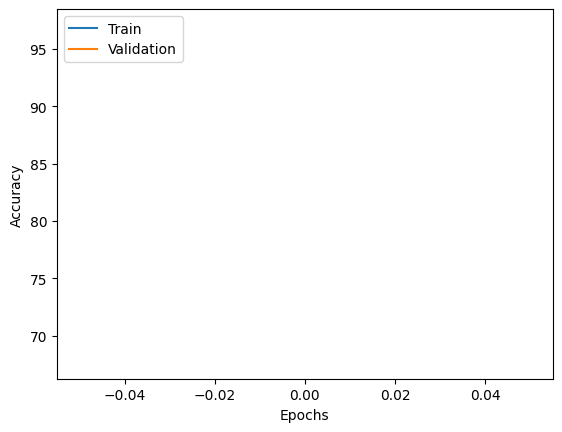

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()